## keras and tensorflow installation

install python 3.6.3 for pip3 as python installed from Anaconda navigator does not have pip3
USe pip3 to install keras and tensorflow
pip3 install keras
pip3 install --upgrade tensorflow

### test tensorflow

conda create -n tensorflow python=3.5
activate tensorflow
python

#import tensorflow as tf
#hello = tf.constant('Hello, TensorFlow!')
#sess = tf.Session()
#print(sess.run(hello))

#### Copy keras from C:\Users\user\Anaconda3\Lib\site-packages\tensorflow\python\ to C:\Users\user\Anaconda3\Lib\site-packages
        

In [4]:
#import numpy
#import pandas
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasRegressor
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold
#from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import Pipeline

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt
import multiprocessing as mp
from datetime import datetime
%matplotlib inline  

In [2]:
import pickle
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

Using TensorFlow backend.


##### Check the range of values stored in the column
##### Check the suitable datatype from the following link https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html
##### Change datatype
##### split date col into three columns
##### There are two reasons to do this
In pandas any operation on column of type "datetime" is not vectorized.Hence any operations on it will take more time
Splitting it into three columns will provide better memory utilization. Eg: in the test dataset date col uses approx. 25 mb while storenbr(uint8) uses approx. 3 mb
##### Impute on promo col
##### join everything

In [2]:
#check the number of cores
num_cores = mp.cpu_count()
print("This kernel has :",num_cores,"cores")

This kernel has : 8 cores


In [2]:
#types_dict = {'id': 'int32',
#             'item_nbr': 'int32',
#             'store_nbr': 'int8',
#             'unit_sales': 'float32'}

### Import train with correct datatypes

##### Import Date and Onpromotion columns and do memory optimization
##### Convert Date column to Year, Month and Day columns

In [3]:
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float16
           }

# read in the date col,on promo col

train_part2=pd.read_csv("data/train.csv",dtype=dtype_dict,usecols=[1,5],parse_dates=[0])
train_part2['Year'] = pd.DatetimeIndex(train_part2['date']).year
train_part2['Month'] = pd.DatetimeIndex(train_part2['date']).month
train_part2['Day'] =pd.DatetimeIndex(train_part2['date']).day.astype(np.uint8)
del(train_part2['date'])
train_part2['Day']=train_part2['Day'].astype(np.uint8)
train_part2['Month']=train_part2['Month'].astype(np.uint8)
train_part2['Year']=train_part2['Year'].astype(np.uint16)

#impute the missing values to be -1
train_part2["onpromotion"].fillna(0, inplace=True)
train_part2["onpromotion"]=train_part2["onpromotion"].astype(np.int8)
print(train_part2.head())
print(train_part2.dtypes)

C:\Users\Tony\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   onpromotion  Year  Month  Day
0            0  2013      1    1
1            0  2013      1    1
2            0  2013      1    1
3            0  2013      1    1
4            0  2013      1    1
onpromotion      int8
Year           uint16
Month           uint8
Day             uint8
dtype: object


##### Import remaining columns

In [4]:
# scaling part 1 to the entire dataset
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32
           }

train_part1 = pd.read_csv("data/train.csv",dtype=dtype_dict,usecols=[0,2,3,4])
print(train_part1.dtypes)

id             uint32
store_nbr       uint8
item_nbr       uint32
unit_sales    float32
dtype: object


##### Join all columns of imported train data

In [5]:
# joining part one and two
# For people familiar with R , the equivalent of cbind in pandas is the following command
train_df = pd.concat([train_part1.reset_index(drop=True), train_part2], axis=1)
#drop temp files
del(train_part1)
del(train_part2)
#Further Id is just an indicator column, hence not required for analysis
id=train_df['id']
del(train_df['id'])
# check memory
print(train_df.memory_usage())
#The extracted train.csv file is approx 5 GB
mem_train=5*1024**3
new_mem_train=train_df.memory_usage().sum()
print("Train dataset uses ",new_mem_train/ 1024**2," MB after changes")
print("memory saved is approx",(mem_train-new_mem_train)/ 1024**2," MB")

Index                 80
store_nbr      125497040
item_nbr       501988160
unit_sales     501988160
onpromotion    125497040
Year           250994080
Month          125497040
Day            125497040
dtype: int64
Train dataset uses  1675.5663299560547  MB after changes
memory saved is approx 3444.4336700439453  MB


##### Randomly sample 10% of your train dataframe

In [7]:
#df = pandas.DataFrame(data)

# Randomly sample 10% of your dataframe
train_df_sample = train_df.sample(frac=0.1)

# Randomly sample 7 elements from your dataframe
#df_7 = df.sample(n=7)

In [11]:
print(train_df_sample.head())
print(train_df_sample.tail())
print(train_df_sample.shape)

           store_nbr  item_nbr  unit_sales  onpromotion  Year  Month  Day
82169466           7    464907       1.000            0  2016      6   15
115307314         33    457928       2.801            0  2017      5   11
105131830         48   2010498       1.000            0  2017      2    3
28761680           5    414478       6.000            0  2014      8    9
62567000          50    414454       6.000            0  2015     11   19
           store_nbr  item_nbr  unit_sales  onpromotion  Year  Month  Day
11228437          41    208659    1.000000            0  2013      9   16
36520726           3   1328495    2.000000            0  2014     12    3
66603319          23   1239798    5.000000            0  2016      1    3
70188575          34   1958185    4.000000            0  2016      2   10
107737521         45   1473488   68.184998            0  2017      2   28
(12549704, 7)


### Load Train Data

In [3]:
#train_df = pd.read_csv('C:\\Users\\Tony\\Documents\\Springboard Bootcamp\\kaggle dataset\\train.csv', low_memory=True, dtype=types_dict)
#print(train_df.shape)
#train_df.head()

C:\Users\Tony\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(125497040, 6)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [37]:
train_df.tail()

,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day
125497035,54,2089339,4.0,0,2017,8,15
125497036,54,2106464,1.0,1,2017,8,15
125497037,54,2110456,192.0,0,2017,8,15
125497038,54,2113914,198.0,1,2017,8,15
125497039,54,2116416,2.0,0,2017,8,15


### Memory Usage for train data

In [12]:
mem_train = train_df_sample.memory_usage(index=True).sum()
print("train dataset uses ",mem_train/ 1024**2," MB")

train dataset uses  263.3032684326172  MB


### Load Test Data

In [13]:
test_df = pd.read_csv('data/test.csv')
test_df['store_nbr'] = test_df['store_nbr'].astype(np.uint8)
test_df['id'] = test_df['id'].astype(np.uint32)
test_df['item_nbr'] = test_df['item_nbr'].astype(np.uint32)

#test_df['date']=pd.to_datetime(test_df['date'],format="%Y-%m-%d")

test_df['Year'] = pd.DatetimeIndex(test_df['date']).year
test_df['Month'] = pd.DatetimeIndex(test_df['date']).month
test_df['Day'] =pd.DatetimeIndex(test_df['date']).day.astype(np.uint8)
del(test_df['date'])
test_df['Day']=test_df['Day'].astype(np.uint8)
test_df['Month']=test_df['Month'].astype(np.uint8)
test_df['Year']=test_df['Year'].astype(np.uint16)

print(test_df.shape)
test_df.head()

(3370464, 7)


,id,store_nbr,item_nbr,onpromotion,Year,Month,Day
0,125497040,1,96995,False,2017,8,16
1,125497041,1,99197,False,2017,8,16
2,125497042,1,103501,False,2017,8,16
3,125497043,1,103520,False,2017,8,16
4,125497044,1,103665,False,2017,8,16


In [14]:
test_df.tail(10)

,id,store_nbr,item_nbr,onpromotion,Year,Month,Day
3370454,128867494,54,2130526,False,2017,8,31
3370455,128867495,54,2130553,False,2017,8,31
3370456,128867496,54,2131010,False,2017,8,31
3370457,128867497,54,2131572,False,2017,8,31
3370458,128867498,54,2131699,False,2017,8,31
3370459,128867499,54,2132163,False,2017,8,31
3370460,128867500,54,2132318,False,2017,8,31
3370461,128867501,54,2132945,False,2017,8,31
3370462,128867502,54,2132957,False,2017,8,31
3370463,128867503,54,2134244,False,2017,8,31


### Load Oil Data

In [30]:
types = {'dcoilwtico': 'float32',
                }
oil_df = pd.read_csv('data/oil.csv', dtype = types)

oil_df['Year'] = pd.DatetimeIndex(oil_df['date']).year
oil_df['Month'] = pd.DatetimeIndex(oil_df['date']).month
oil_df['Day'] =pd.DatetimeIndex(oil_df['date']).day.astype(np.uint8)
del(oil_df['date'])
oil_df['Day']=oil_df['Day'].astype(np.uint8)
oil_df['Month']=oil_df['Month'].astype(np.uint8)
oil_df['Year']=oil_df['Year'].astype(np.uint16)

print(oil_df.shape)
oil_df.head()
print(oil_df.dtypes)

(1218, 4)
dcoilwtico    float32
Year           uint16
Month           uint8
Day             uint8
dtype: object


### Load Items Data

In [8]:
types = {'item_nbr': 'int32',
                'perishable': 'int8',
                'class' : 'int16'
                }
items_df = pd.read_csv('data/items.csv', dtype = types)
print(items_df.shape)
print(items_df.head())
print(items_df.dtypes)
#print(items_df[item_nbr].

(4100, 4)
   item_nbr        family  class  perishable
0     96995     GROCERY I   1093           0
1     99197     GROCERY I   1067           0
2    103501      CLEANING   3008           0
3    103520     GROCERY I   1028           0
4    103665  BREAD/BAKERY   2712           1
item_nbr       int32
family        object
class          int16
perishable      int8
dtype: object
<bound method DataFrame.max of       item_nbr            family  class  perishable
0        96995         GROCERY I   1093           0
1        99197         GROCERY I   1067           0
2       103501          CLEANING   3008           0
3       103520         GROCERY I   1028           0
4       103665      BREAD/BAKERY   2712           1
5       105574         GROCERY I   1045           0
6       105575         GROCERY I   1045           0
7       105576         GROCERY I   1045           0
8       105577         GROCERY I   1045           0
9       105693         GROCERY I   1034           0
10      105737     

### Load Holiday Data

In [17]:
holidays_events_df = pd.read_csv('data/holidays_events.csv')

holidays_events_df['Year'] = pd.DatetimeIndex(holidays_events_df['date']).year
holidays_events_df['Month'] = pd.DatetimeIndex(holidays_events_df['date']).month
holidays_events_df['Day'] =pd.DatetimeIndex(holidays_events_df['date']).day.astype(np.uint8)
del(holidays_events_df['date'])
holidays_events_df['Day']=holidays_events_df['Day'].astype(np.uint8)
holidays_events_df['Month']=holidays_events_df['Month'].astype(np.uint8)
holidays_events_df['Year']=holidays_events_df['Year'].astype(np.uint16)

print(holidays_events_df.shape)
holidays_events_df.head()

(350, 8)


,type,locale,locale_name,description,transferred,Year,Month,Day
0,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2
1,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1
2,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12
3,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14
4,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21


### Load Stores Data

In [18]:
stores_df = pd.read_csv('data/stores.csv')
print(stores_df.shape)
stores_df.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Load Transactions Data

In [19]:
transactions_df = pd.read_csv('data/transactions.csv')

# Conveting date to year, month, day format

transactions_df['Year'] = pd.DatetimeIndex(transactions_df['date']).year
transactions_df['Month'] = pd.DatetimeIndex(transactions_df['date']).month
transactions_df['Day'] =pd.DatetimeIndex(transactions_df['date']).day.astype(np.uint8)
del(transactions_df['date'])
transactions_df['Day']=transactions_df['Day'].astype(np.uint8)
transactions_df['Month']=transactions_df['Month'].astype(np.uint8)
transactions_df['Year']=transactions_df['Year'].astype(np.uint16)

transactions_df['transactions']=transactions_df['transactions'].astype(np.uint16)

print(transactions_df.shape)
transactions_df.head()

(83488, 5)


,store_nbr,transactions,Year,Month,Day
0,25,770,2013,1,1
1,1,2111,2013,1,2
2,2,2358,2013,1,2
3,3,3487,2013,1,2
4,4,1922,2013,1,2


### MERGE Train and transactions Data

In [46]:
train_transactions_df = pd.merge(train_df_sample, transactions_df, on=['Year', 'Month', 'Day', 'store_nbr'])

#Memory usage for Merged train and transaction dataframe

mem_train = train_transactions_df.memory_usage(index=True).sum()
print("Merged train and transactions dataset uses ",mem_train/ 1024**2," MB")

print("Data types of train data frame ",train_df.dtypes)
print("Data types of merged train and transactions data frame ", train_transactions_df.dtypes)
print("Shape of train_transaction dataframe ", train_transactions_df.shape)

print("Max value for transaction ", train_transactions_df['transactions'].min())
print("Min value for transactions ", train_transactions_df['transactions'].max())

train_transactions_df.head()

Merged train and transactions dataset uses  286.7487487792969  MB
Data types of train data frame  store_nbr        uint8
item_nbr        uint32
unit_sales     float32
onpromotion       int8
Year            uint16
Month            uint8
Day              uint8
dtype: object
Data types of merged train and transactions data frame  store_nbr         uint8
item_nbr         uint32
unit_sales      float32
onpromotion        int8
Year             uint16
Month             uint8
Day               uint8
transactions     uint16
dtype: object
Shape of train_transaction dataframe  (12528244, 8)
Max value for transaction  6
Min value for transactions  8359


,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day,transactions
0,7,464907,1.000,0,2016,6,15,1939
1,7,843585,27.000,0,2016,6,15,1939
2,7,695758,10.847,1,2016,6,15,1939
3,7,119187,3.000,0,2016,6,15,1939
4,7,1334074,2.000,0,2016,6,15,1939


### MERGE Train,transactions and items Data

In [47]:
train_transactions_items_df = pd.merge(train_transactions_df, items_df, on=['item_nbr'])

#Memory usage for Merged data

mem_train = train_transactions_items_df.memory_usage(index=True).sum()
print("Merged train, transaCtions and items dataset uses ",mem_train/ 1024**2," MB")

print("Data types of merged train and transactions data frame ", train_transactions_items_df.dtypes)
print("Data types of merged train, transactions and items data frame ", train_transactions_df.dtypes)
print("Shape of train_transactions_items dataframe", train_transactions_df.shape)

print("Max value for transaction in the merged df", train_transactions_df['transactions'].min())
print("Min value for transactions in the merged df", train_transactions_df['transactions'].max())

train_transactions_items_df.head()

Merged train, transaCtions and items dataset uses  418.1752586364746  MB
Data types of merged train and transactions data frame  store_nbr         uint8
item_nbr         uint32
unit_sales      float32
onpromotion        int8
Year             uint16
Month             uint8
Day               uint8
transactions     uint16
family           object
class             int16
perishable         int8
dtype: object
Data types of merged train, transactions and items data frame  store_nbr         uint8
item_nbr         uint32
unit_sales      float32
onpromotion        int8
Year             uint16
Month             uint8
Day               uint8
transactions     uint16
dtype: object
Shape of train_transactions_items dataframe (12528244, 8)
Max value for transaction in the merged df 6
Min value for transactions in the merged df 8359


,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day,transactions,family,class,perishable
0,7,464907,1.0,0,2016,6,15,1939,GROCERY I,1056,0
1,13,464907,5.0,0,2013,6,12,877,GROCERY I,1056,0
2,48,464907,9.0,0,2014,5,5,3020,GROCERY I,1056,0
3,14,464907,3.0,0,2016,2,1,1465,GROCERY I,1056,0
4,38,464907,2.0,0,2014,5,13,1474,GROCERY I,1056,0


### MERGE Train, transactions, Items and Stores Data

In [49]:
train_transactions_items_stores_df = pd.merge(train_transactions_items_df, stores_df, on=['store_nbr'])

mem_train = train_transactions_items_stores_df.memory_usage(index=True).sum()
print("Merged train_transactions_items_stores dataset uses ",mem_train/ 1024**2," MB")

print("Data types of merged train, transactions, items, stores data frame ", train_transactions_items_stores_df.dtypes)
print("Shape of train_transactions_items_stores dataframe", train_transactions_items_stores_df.shape)

print("Max value for transactions in the merged df", train_transactions_items_stores_df['transactions'].min())
print("Min value for transactions in the merged df", train_transactions_items_stores_df['transactions'].max())

train_transactions_items_stores_df.head()

Merged train_transactions_items_stores dataset uses  800.5069236755371  MB
Data types of merged train, transactions, items, stores data frame  store_nbr         uint8
item_nbr         uint32
unit_sales      float32
onpromotion        int8
Year             uint16
Month             uint8
Day               uint8
transactions     uint16
family           object
class             int16
perishable         int8
city             object
state            object
type             object
cluster           int64
dtype: object
Shape of train_transactions_items_stores dataframe (12528244, 15)
Max value for transactions in the merged df 6
Min value for transactions in the merged df 8359


,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day,transactions,family,class,perishable,city,state,type,cluster
0,7,464907,1.0,0,2016,6,15,1939,GROCERY I,1056,0,Quito,Pichincha,D,8
1,7,464907,1.0,0,2013,1,9,1525,GROCERY I,1056,0,Quito,Pichincha,D,8
2,7,464907,1.0,0,2016,6,19,1689,GROCERY I,1056,0,Quito,Pichincha,D,8
3,7,464907,1.0,0,2017,6,3,1994,GROCERY I,1056,0,Quito,Pichincha,D,8
4,7,464907,1.0,0,2016,7,29,1874,GROCERY I,1056,0,Quito,Pichincha,D,8


### MERGE Train, transactions, Items, Stores and Oil Data

In [50]:
train_transactions_items_stores_oil_df = pd.merge(train_transactions_items_stores_df, oil_df, how='left', on=['Year', 'Month', 'Day'])

mem_train = train_transactions_items_stores_oil_df.memory_usage(index=True).sum()
print("train dataset uses ",mem_train/ 1024**2," MB")

print("Data types of merged train, transactions, items, Stores and oil data frame ", train_transactions_items_stores_oil_df.dtypes)
print("Shape of train_transactions_items_stores_oil dataframe", train_transactions_items_stores_oil_df.shape)

print("Max value for transaction in the merged df", train_transactions_items_stores_oil_df['transactions'].min())
print("Min value for transactions in the merged df", train_transactions_items_stores_oil_df['transactions'].max())

train_transactions_items_stores_oil_df.head()

train dataset uses  848.2983818054199  MB
Data types of merged train, transactions, items, Stores and oil data frame  store_nbr         uint8
item_nbr         uint32
unit_sales      float32
onpromotion        int8
Year             uint16
Month             uint8
Day               uint8
transactions     uint16
family           object
class             int16
perishable         int8
city             object
state            object
type             object
cluster           int64
dcoilwtico      float32
dtype: object
Shape of train_transactions_items_stores_oil dataframe (12528244, 16)
Max value for transaction in the merged df 6
Min value for transactions in the merged df 8359


,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day,transactions,family,class,perishable,city,state,type,cluster,dcoilwtico
0,7,464907,1.0,0,2016,6,15,1939,GROCERY I,1056,0,Quito,Pichincha,D,8,47.919998
1,7,464907,1.0,0,2013,1,9,1525,GROCERY I,1056,0,Quito,Pichincha,D,8,93.080002
2,7,464907,1.0,0,2016,6,19,1689,GROCERY I,1056,0,Quito,Pichincha,D,8,NaN
3,7,464907,1.0,0,2017,6,3,1994,GROCERY I,1056,0,Quito,Pichincha,D,8,NaN
4,7,464907,1.0,0,2016,7,29,1874,GROCERY I,1056,0,Quito,Pichincha,D,8,41.540001


### MERGE Train, transactions, Items, Stores, Oil and holiday Data

In [51]:
#print("Transactions Sum from transactions dataset " + str(transactions_df['transactions'].sum()))
#print("Sales sum from train dataset " + str(train_df['unit_sales'].sum()))

In [52]:
train_transactions_items_stores_oil_holiday_df = pd.merge(train_transactions_items_stores_oil_df, holidays_events_df, how='left', on=['Year', 'Month', 'Day'])

mem_train = train_transactions_items_stores_oil_holiday_df.memory_usage(index=True).sum()
print("train dataset uses ",mem_train/ 1024**2," MB")

print("Data types of merged train, transactions, items, Stores, oil and holiday data frame ", train_transactions_items_stores_oil_holiday_df.dtypes)
print("Shape of train_transactions_items_stores_oil_holiday dataframe", train_transactions_items_stores_oil_holiday_df.shape)

print("Max value for transaction in the merged df", train_transactions_items_stores_oil_holiday_df['transactions'].min())
print("Min value for transactions in the merged df", train_transactions_items_stores_oil_holiday_df['transactions'].max())

train_transactions_items_stores_oil_holiday_df.head()

train dataset uses  1352.4067468643188  MB
Data types of merged train, transactions, items, Stores, oil and holiday data frame  store_nbr         uint8
item_nbr         uint32
unit_sales      float32
onpromotion        int8
Year             uint16
Month             uint8
Day               uint8
transactions     uint16
family           object
class             int16
perishable         int8
city             object
state            object
type_x           object
cluster           int64
dcoilwtico      float32
type_y           object
locale           object
locale_name      object
description      object
transferred      object
dtype: object
Shape of train_transactions_items_stores_oil_holiday dataframe (12775687, 21)
Max value for transaction in the merged df 6
Min value for transactions in the merged df 8359


,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day,transactions,family,class,...,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,7,464907,1.0,0,2016,6,15,1939,GROCERY I,1056,...,Quito,Pichincha,D,8,47.919998,NaN,NaN,NaN,NaN,NaN
1,7,464907,1.0,0,2013,1,9,1525,GROCERY I,1056,...,Quito,Pichincha,D,8,93.080002,NaN,NaN,NaN,NaN,NaN
2,7,464907,1.0,0,2016,6,19,1689,GROCERY I,1056,...,Quito,Pichincha,D,8,NaN,NaN,NaN,NaN,NaN,NaN
3,7,464907,1.0,0,2017,6,3,1994,GROCERY I,1056,...,Quito,Pichincha,D,8,NaN,NaN,NaN,NaN,NaN,NaN
4,7,464907,1.0,0,2016,7,29,1874,GROCERY I,1056,...,Quito,Pichincha,D,8,41.540001,NaN,NaN,NaN,NaN,NaN


#### Export merged data to csv

In [54]:
train_transactions_items_stores_oil_holiday_df.tail()
train_transactions_items_stores_oil_holiday_df.to_csv('data/train_merged.csv')

#### Import the 10% sample data from merged csv file to merged_df dataframe with memory optimization

In [3]:
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32,
            "onpromotion":np.uint8,
            "Year":np.uint16,
            "Month":np.uint8,
            "Day":np.uint8,
            "transactions":np.uint16,
            "class":np.uint16,
            "perishable":np.uint8,
            "cluster":np.uint8,
            "dcoilwtico":np.float32
           }

merged_df = pd.read_csv('data/train_merged.csv', dtype=dtype_dict)

mem_train = merged_df.memory_usage(index=True).sum()
print("train dataset uses ",mem_train/ 1024**2," MB")

print(merged_df.dtypes)
merged_df.head()

train dataset uses  1267.1199111938477  MB
Unnamed: 0        int64
store_nbr         uint8
item_nbr         uint32
unit_sales      float32
onpromotion       uint8
Year             uint16
Month             uint8
Day               uint8
transactions     uint16
family           object
class            uint16
perishable        uint8
city             object
state            object
type_x           object
cluster           uint8
dcoilwtico      float32
type_y           object
locale           object
locale_name      object
description      object
transferred      object
dtype: object


,Unnamed: 0,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day,transactions,family,...,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,7,464907,1.0,0,2016,6,15,1939,GROCERY I,...,Quito,Pichincha,D,8,47.919998,NaN,NaN,NaN,NaN,NaN
1,1,7,464907,1.0,0,2013,1,9,1525,GROCERY I,...,Quito,Pichincha,D,8,93.080002,NaN,NaN,NaN,NaN,NaN
2,2,7,464907,1.0,0,2016,6,19,1689,GROCERY I,...,Quito,Pichincha,D,8,NaN,NaN,NaN,NaN,NaN,NaN
3,3,7,464907,1.0,0,2017,6,3,1994,GROCERY I,...,Quito,Pichincha,D,8,NaN,NaN,NaN,NaN,NaN,NaN
4,4,7,464907,1.0,0,2016,7,29,1874,GROCERY I,...,Quito,Pichincha,D,8,41.540001,NaN,NaN,NaN,NaN,NaN


In [27]:
#merged_df.groupby('item_nbr').nunique()

##### Convert Year, Month, Day to datetime and add that as Date column

In [4]:
merged_df['Date'] = merged_df.apply(lambda row: datetime(
                              row['Year'], row['Month'], row['Day']), axis=1)
mem_train = merged_df.memory_usage(index=True).sum()
print("train dataset uses ",mem_train/ 1024**2," MB")

train dataset uses  1364.5906677246094  MB


In [36]:
merged_df.head()

,Unnamed: 0,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day,transactions,family,...,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred,Date
0,0,7,464907,1.0,0,2016,6,15,1939,GROCERY I,...,Pichincha,D,8,47.919998,NaN,NaN,NaN,NaN,NaN,2016-06-15
1,1,7,464907,1.0,0,2013,1,9,1525,GROCERY I,...,Pichincha,D,8,93.080002,NaN,NaN,NaN,NaN,NaN,2013-01-09
2,2,7,464907,1.0,0,2016,6,19,1689,GROCERY I,...,Pichincha,D,8,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-19
3,3,7,464907,1.0,0,2017,6,3,1994,GROCERY I,...,Pichincha,D,8,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-03
4,4,7,464907,1.0,0,2016,7,29,1874,GROCERY I,...,Pichincha,D,8,41.540001,NaN,NaN,NaN,NaN,NaN,2016-07-29


##### Sales variation for each month of a year

In [50]:
#sales = merged_df.groupby(['Year','Month'])['unit_sales'].sum()
#print(sales)

##### Plot of sales per month of each year

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]), <a list of 56 Text xticklabel objects>)

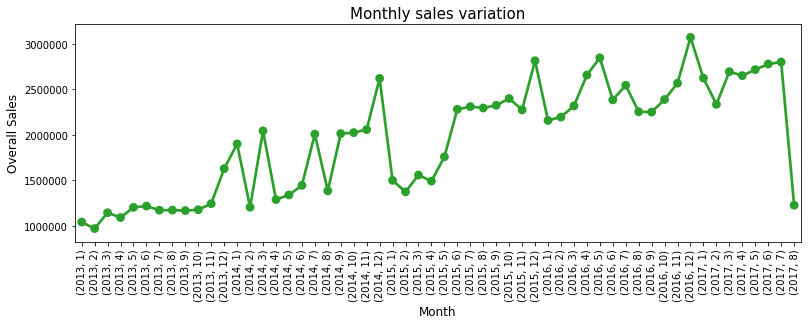

In [46]:
sales = merged_df.groupby(['Year','Month'])['unit_sales'].sum()
plt.figure(figsize=(13,4))
sns.pointplot(sales.index,sales.values, alpha=0.8, color=color[2],)
plt.ylabel('Overall Sales', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Monthly sales variation', fontsize=15)
plt.xticks(rotation='vertical')

In [43]:
#sales = merged_df.groupby(['Year','Month'])['unit_sales'].sum()
#sales.unstack().plot(kind='bar', stacked = True, figsize=(13,11), grid=True)

##### Plot sales for city and store number

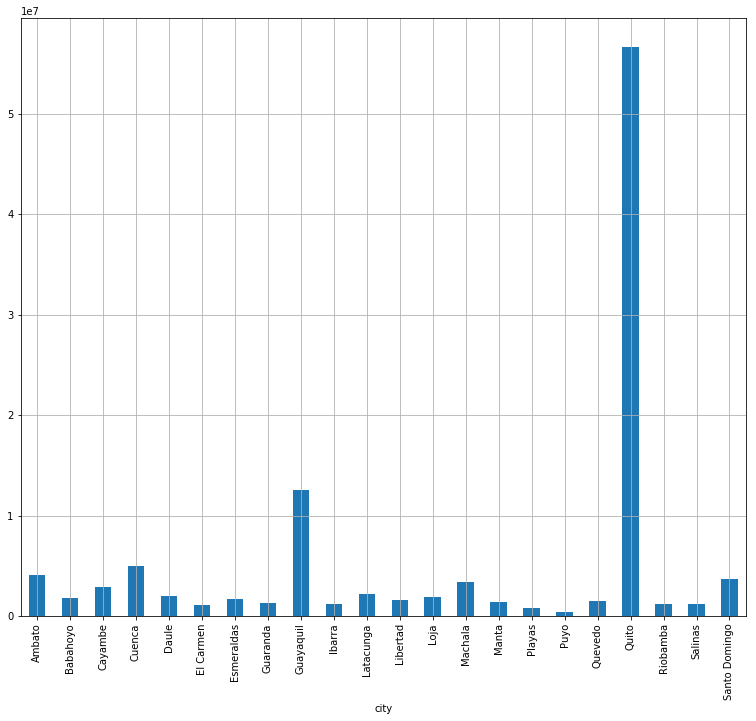

In [93]:
sales = merged_df.groupby(['city'])['unit_sales'].sum()
#sales.unstack().plot(kind='bar', stacked = True, figsize=(13,11), grid=True)
sales.plot(kind='bar', figsize=(13,11), grid=True)

In [31]:
#sales = merged_df.groupby(['city', 'store_nbr'])['unit_sales'].sum()
#print(sales)

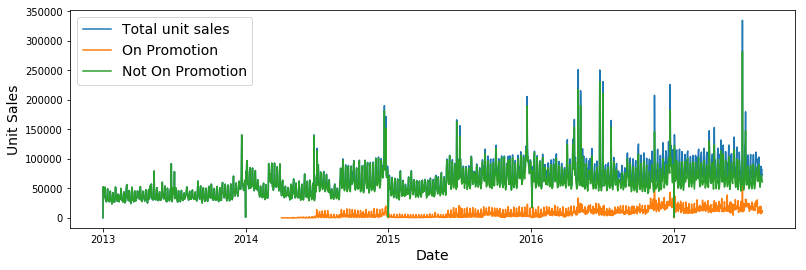

In [68]:
plt.figure(figsize=(13,4))

#df_plot.Date = pd.to_datetime(df_plot.Date)
# plot total sales
df_plot = merged_df.groupby(by=['Date']).agg({'unit_sales':'sum'}).reset_index()
plt.plot(df_plot.Date, df_plot.unit_sales)

df_plot = merged_df.loc[merged_df['onpromotion']==True].groupby(by=['Date']).agg({'unit_sales':'sum'}).reset_index()
plt.plot(df_plot.Date, df_plot.unit_sales)


# plot unit sales not on promotion
df_plot = merged_df.loc[merged_df['onpromotion'] == False].groupby(by=['Date']).agg({'unit_sales':'sum'}).reset_index()
plt.plot(df_plot.Date, df_plot.unit_sales)


# Set the labels
plt.xlabel('Date',fontsize=14)
plt.ylabel('Unit Sales',fontsize=14)

# Set the legend
plt.legend(['Total unit sales','On Promotion','Not On Promotion'], fontsize=14)

#### Stores by year

There was an increase in number of stores each year

Text(0,0.5,'# of stores')

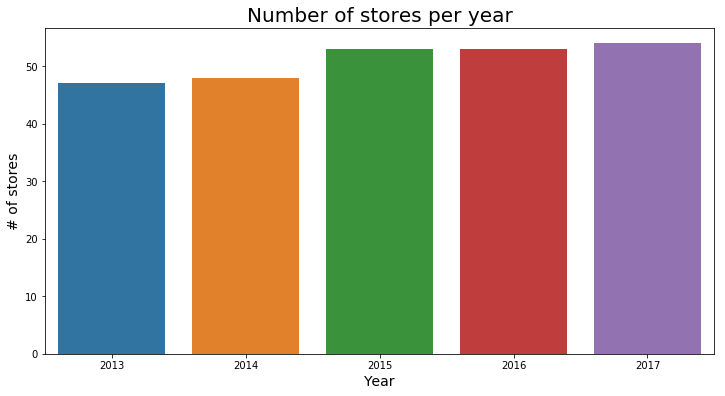

In [90]:
df_plot = merged_df.groupby(merged_df.Date.dt.year)['store_nbr'].nunique().reset_index()

#Set the plot figure
plt.figure(figsize=(12,6))

#plot title
plt.title('Number of stores per year', fontsize=20)
sns.barplot(data=df_plot, x='Date', y='store_nbr')
plt.xlabel('Year', fontsize=14)
plt.ylabel('# of stores', fontsize=14)
#print(df_plot)

### Load sample submission Data

In [18]:
sample_submission_df = pd.read_csv('data/sample_submission.csv')
print(sample_submission_df.shape)
sample_submission_df.head()

(3370464, 2)


,id,unit_sales
0,125497040,0
1,125497041,0
2,125497042,0
3,125497043,0
4,125497044,0



#### Stacked barplot of types of stores across the different cities

Another interesting distribution to observe would be the types of stores that Corporacion Favorita has decided to open for each city in Ecuador as well as the absolute number of stores for that city. All these three things can be achieved by turning to our usual groupby operation and pivoting again by unstacking and plotting as follows:

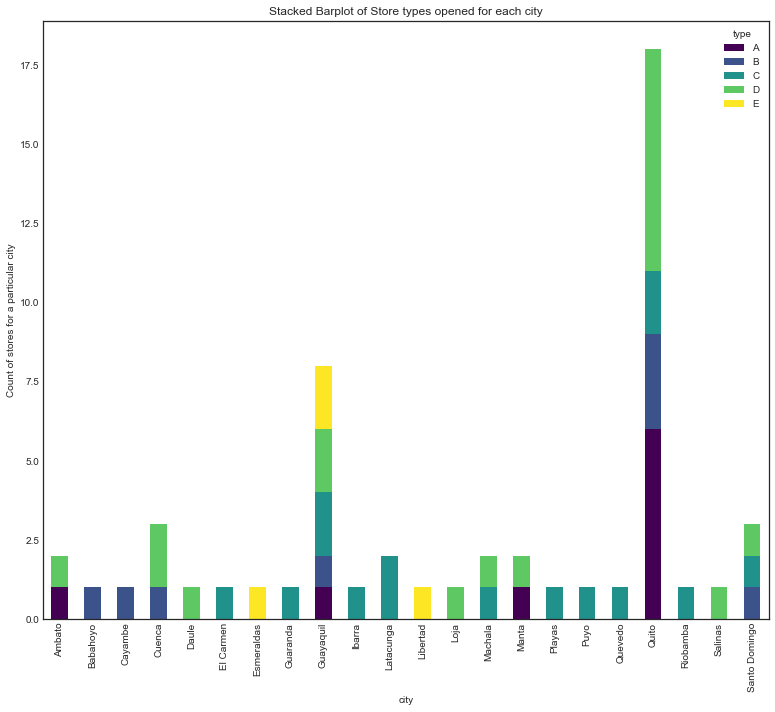

In [24]:
# plt.style.use('dark_background')
plt.style.use('seaborn-white')
city_cluster = stores_df.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()

#### Holiday Events data

Trudging on, we can inspect the "holiday_events.csv" file which contains data on the national, regional and local level of Ecuador. According to the data dictionary, we should pay special attention to the "transferred" column.
A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

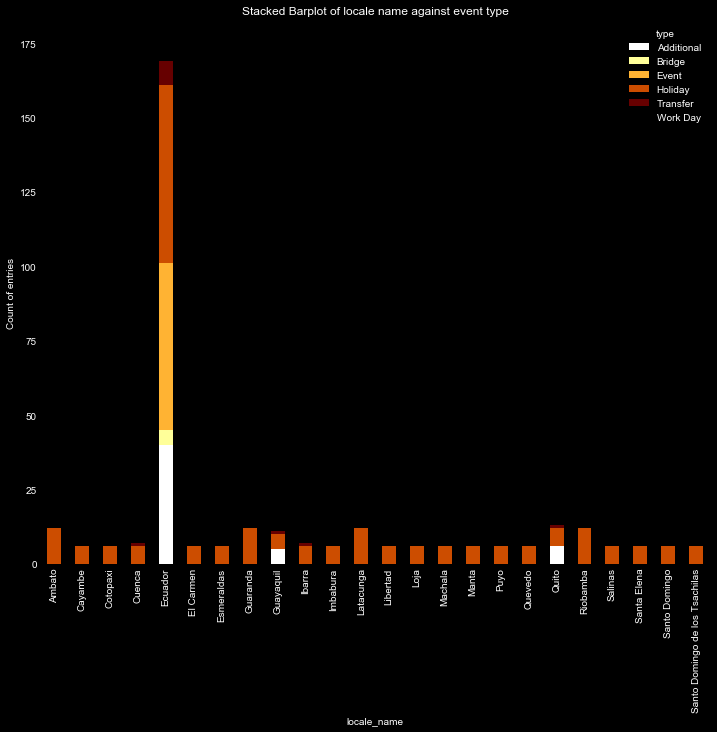

In [26]:
plt.style.use('seaborn-dark')
plt.style.use('dark_background')
holiday_local_type = holidays_events_df.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'afmhot_r', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

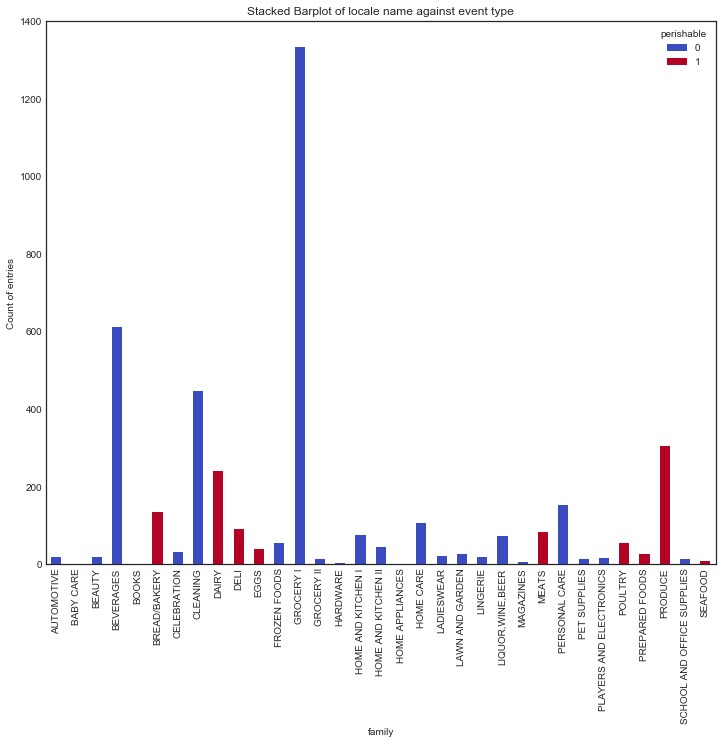

In [30]:
plt.style.use('seaborn-white')
fam_perishable = items_df.groupby(['family', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar',stacked=True, colormap= 'coolwarm', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()